In [1]:
%pylab inline
numpy.random.seed(0)

import seaborn; seaborn.set_style('whitegrid')

from apricot import FeatureBasedSelection
from apricot import FacilityLocationSelection

Populating the interactive namespace from numpy and matplotlib


### Sparse Inputs

Sometimes your data has many zeroes in it. Sparse matrices, implemented through `scipy.sparse`, are a way of storing only those values that are non-zero. This can be an extremely efficient way to represent massive data sets that mostly have zero values, such as sentences that are featurized using the presence of n-grams. Simple modifications can be made to many algorithms to operate on the sparse representations of these data sets, enabling compute to be efficiently performed on data whose dense representation may not even fit in memory. The submodular optimization algorithms implemented in apricot are some such algorithms.

Let's start off with loading three data sets in scikit-learn that have many zeros in them, and show the density, which is the percentage of non-zero elements in them.

In [2]:
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_covtype
from sklearn.datasets import fetch_rcv1

X_digits = load_digits().data.astype('float64')
X_covtype = numpy.abs(fetch_covtype().data).astype('float64')
X_rcv1 = fetch_rcv1().data[:5000].toarray()

print("digits density: ", (X_digits != 0).mean())
print("covtype density: ", (X_covtype != 0).mean())
print("rcv1 density: ", (X_rcv1 != 0).mean())

digits density:  0.5107122982749026
covtype density:  0.21997936040589205
rcv1 density:  0.0015492886781268524


It looks like these three data sets have very different levels of sparsity. The digits data set is approximately half non-zeros, the covertypes data set is approximately one-fifth non-zeroes, and the rcv1 subset we're using is less than 0.2% non-zeroes.

Let's see how long it takes to rank the digits data set using only naive greedy selection.

In [3]:
%timeit FeatureBasedSelection(X_digits.shape[0], 'sqrt', optimizer='naive').fit(X_digits)

1.46 s ± 60 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can turn our dense numpy array into a sparse array using `scipy.sparse.csr_matrix`. Currently, apricot only accepts `csr` formatted sparse matrices. This creates a matrix where each row is stored contiguously, rather than each column being stored contiguously. This is helpful for us because each row corresponds to an example in our data set. No other changes are needed other than passing in a `csr_matrix` rather than a numpy array.

In [4]:
from scipy.sparse import csr_matrix

X_digits_sparse = csr_matrix(X_digits)

%timeit FeatureBasedSelection(X_digits.shape[0], 'sqrt', optimizer='naive').fit(X_digits_sparse)

1.79 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like things may have been slowed down a bit, likely due to a comination of the data set being small and not particularly sparse.

Let's look at the covertypes data set, which is both much larger and much sparser.

In [5]:
FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X_covtype).ranking[:10]

100%|██████████| 500/500 [00:10<00:00, 47.4it/s] 


array([ 60562, 478758,  61159,  56653,  60561, 478759,  60262,  57263,
       478760,  60861])

In [6]:
X_covtype_sparse = csr_matrix(X_covtype)

FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X_covtype_sparse).ranking[:10]

100%|██████████| 500/500 [00:05<00:00, 85.1it/s] 


array([ 60562, 478758,  61159,  56653,  60561, 478759,  60262,  57263,
       478760,  60861])

Seems like it might only be a little bit beneficial in terms of speed, here.

Let's take a look at our last data set, the subset from rcv1, which is extremely sparse.

In [7]:
FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X_rcv1).ranking[:10]

100%|██████████| 500/500 [01:04<00:00, 7.81it/s] 


array([ 363,  362, 2919, 2959, 4086, 4564, 1060, 2930,  268, 1506])

In [8]:
X_rcv1_sparse = csr_matrix(X_rcv1)

FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X_rcv1_sparse).ranking[:10]

100%|██████████| 500/500 [00:11<00:00, 44.2it/s]


array([ 363,  362, 2919, 2959, 4086, 4564, 1060, 2930,  268, 1506])

It looks like there is a massive speed improvement here. It looks like the sparseness of a data set may contribute to the speed improvements one would get when using a sparse array versus a dense array. 

As a side note, only a small subset of the rcv1 data set is used here because, while the sparse array does fit in memory, the dense array does not. This illustrates that, even when there isn't a significant speed advantage, support for sparse arrays in general can be necessary for massive data problems. For example, here's an example of apricot easily finding the least redundant subset of size 1,000 from the entire 804,414 example x 47,236 feature rcv1 data set, which would require >250 GB to store at 64-bit floats. 

In [9]:
X_rcv1_sparse = fetch_rcv1().data

FeatureBasedSelection(1000, 'sqrt', verbose=True).fit(X_rcv1_sparse)

100%|█████████▉| 999/1.00k [01:17<00:00, 10.6it/s] 

0.5441014766693115 23.813040733337402 5.747008323669434


100%|██████████| 1.00k/1.00k [01:18<00:00, 12.8it/s]


Clearly there seems to be a speed benefit as data sets become larger. But can we quantify it further? Let's look at a large, randomly generated sparse data set. 

In [10]:
numpy.random.seed(0)
X = numpy.random.choice(2, size=(8000, 4000), p=[0.99, 0.01]).astype('float64')

In [11]:
FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X).ranking[:10]

100%|██████████| 500/500 [00:09<00:00, 51.2it/s] 


array([5548, 1726, 3051, 3445, 2539,  556, 2211, 4262,  633, 6060])

In [12]:
X_sparse = csr_matrix(X)

FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X_sparse).ranking[:10]

100%|██████████| 500/500 [00:00<00:00, 658it/s]  


array([5548, 1726, 3051, 3445, 2539,  556, 2211, 4262,  633, 6060])

It looks much faster to use a sparse matrix for this data set. But, is it faster to use a sparse matrix because the data set is larger, or because we're leveraging the format of a sparse matrix?

In [13]:
import time

sizes = 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000, 50000 
times, sparse_times = [], []
for n in sizes:
    X = numpy.random.choice(2, size=(n, 4000), p=[0.99, 0.01]).astype('float64')
    
    tic = time.time()
    FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X)
    times.append(time.time() - tic)
    
    X = csr_matrix(X)

    tic = time.time()
    FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X)
    sparse_times.append(time.time() - tic)

100%|██████████| 500/500 [00:02<00:00, 224it/s] 


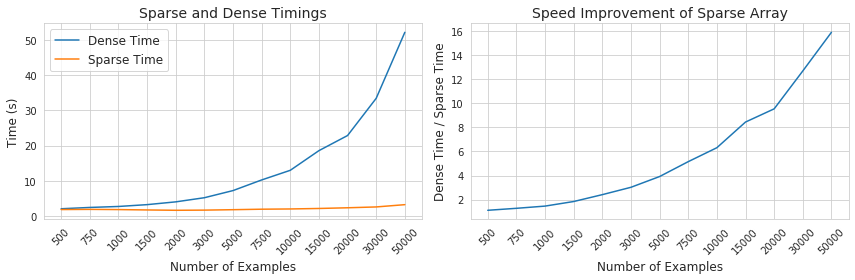

In [14]:
ratio = numpy.array(times) / numpy.array(sparse_times)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Sparse and Dense Timings", fontsize=14)
plt.plot(times, label="Dense Time")
plt.plot(sparse_times, label="Sparse Time")
plt.legend(fontsize=12)
plt.xticks(range(len(sizes)), sizes, rotation=45)
plt.xlabel("Number of Examples", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)

plt.subplot(122)
plt.title("Speed Improvement of Sparse Array", fontsize=14)
plt.plot(ratio)
plt.xticks(range(len(sizes)), sizes, rotation=45)
plt.xlabel("Number of Examples", fontsize=12)
plt.ylabel("Dense Time / Sparse Time", fontsize=12)

plt.tight_layout()
plt.show()

It looks like, at a fixed sparsity, the larger the data set is, the larger the speed up is.

What happens if we vary the number of features in a data set with a fixed number of examples and sparsity?

In [15]:
sizes = 5, 10, 25, 50, 100, 150, 200, 250, 500, 1000, 2000, 5000, 10000, 15000, 20000, 25000
times, sparse_times = [], []
for d in sizes:
    X = numpy.random.choice(2, size=(10000, d), p=[0.99, 0.01]).astype('float64')
    
    tic = time.time()
    FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X)
    times.append(time.time() - tic)
    
    X = csr_matrix(X)

    tic = time.time()
    FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X)
    sparse_times.append(time.time() - tic)

100%|██████████| 500/500 [00:06<00:00, 76.2it/s]


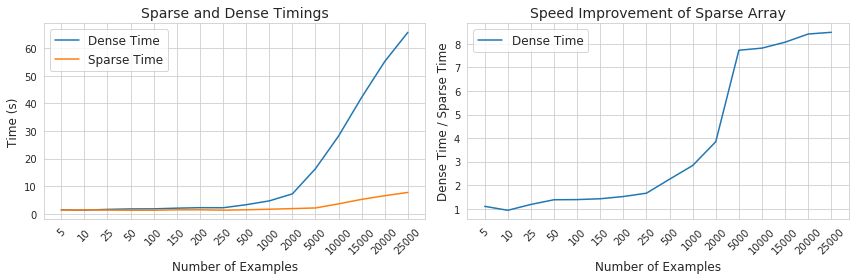

In [16]:
ratio = numpy.array(times) / numpy.array(sparse_times)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Sparse and Dense Timings", fontsize=14)
plt.plot(times, label="Dense Time")
plt.plot(sparse_times, label="Sparse Time")
plt.legend(fontsize=12)
plt.xticks(range(len(sizes)), sizes, rotation=45)
plt.xlabel("Number of Examples", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)

plt.subplot(122)
plt.title("Speed Improvement of Sparse Array", fontsize=14)
plt.plot(ratio, label="Dense Time")
plt.legend(fontsize=12)
plt.xticks(range(len(sizes)), sizes, rotation=45)
plt.xlabel("Number of Examples", fontsize=12)
plt.ylabel("Dense Time / Sparse Time", fontsize=12)

plt.tight_layout()
plt.show()

Looks like we're getting a similar speed improvement as we increase the number of features.

Lastly, what happens when we change the sparsity?

In [17]:
ps = 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99, 0.995, 0.999
times, sparse_times = [], []
for p in ps:
    X = numpy.random.choice(2, size=(50000, 1000), p=[p, 1-p]).astype('float64')
    
    tic = time.time()
    FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X)
    times.append(time.time() - tic)
    
    X = csr_matrix(X)

    tic = time.time()
    FeatureBasedSelection(500, 'sqrt', optimizer='naive', verbose=True).fit(X)
    sparse_times.append(time.time() - tic)

100%|██████████| 500/500 [00:00<00:00, 1.38kit/s]


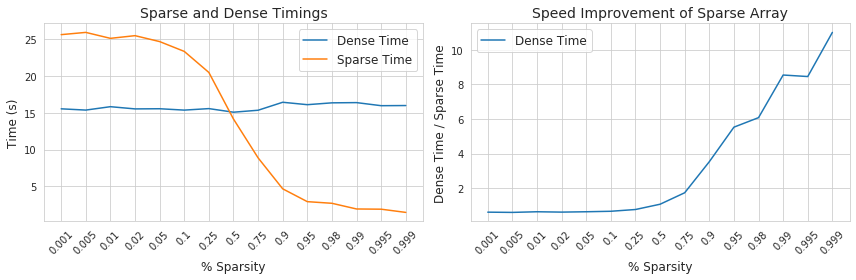

In [18]:
ratio = numpy.array(times) / numpy.array(sparse_times)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Sparse and Dense Timings", fontsize=14)
plt.plot(times, label="Dense Time")
plt.plot(sparse_times, label="Sparse Time")
plt.legend(fontsize=12)
plt.xticks(range(len(ps)), ps, rotation=45)
plt.xlabel("% Sparsity", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)

plt.subplot(122)
plt.title("Speed Improvement of Sparse Array", fontsize=14)
plt.plot(ratio, label="Dense Time")
plt.legend(fontsize=12)
plt.xticks(range(len(ps)), ps, rotation=45)
plt.xlabel("% Sparsity", fontsize=12)
plt.ylabel("Dense Time / Sparse Time", fontsize=12)

plt.tight_layout()
plt.show()

This looks like it may be the most informative plot. This says that, given data sets of the same size, operating on a sparse array will be significantly slower than a dense array until the data set gets to a certain sparsity level. For this data set it was approximately 75% zeros, but for other data sets it may differ.

These examples have so far focused on the time it takes to select using feature based functions. However, facility location functions can take sparse input, as long as it is the pre-computed similarity matrix that is sparse, not the feature matrix.

In [19]:
X = numpy.random.uniform(0, 1, size=(6000, 6000))
X = (X + X.T) / 2.
X[X < 0.9] = 0.0
X_sparse = csr_matrix(X)

In [20]:
FacilityLocationSelection(500, 'precomputed', optimizer='naive', verbose=True).fit(X)

100%|██████████| 500/500 [00:08<00:00, 60.3it/s] 


In [21]:
FacilityLocationSelection(500, 'precomputed', optimizer='naive', verbose=True).fit(X_sparse)

100%|██████████| 500/500 [00:00<00:00, 1.13kit/s]


It looks selection works significantly faster on a sparse array than on a dense one. We can do a similar type of analysis as before to analyze the components.

In [22]:
sizes = range(500, 8001, 500)
times, sparse_times = [], []
for d in sizes:
    X = numpy.random.uniform(0, 1, size=(d, d)).astype('float64')
    X = (X + X.T) / 2
    X[X <= 0.9] = 0
    
    tic = time.time()
    FacilityLocationSelection(500, 'precomputed', optimizer='naive', verbose=True).fit(X)
    times.append(time.time() - tic)
    
    X = csr_matrix(X)

    tic = time.time()
    FacilityLocationSelection(500, 'precomputed', optimizer='naive', verbose=True).fit(X)
    sparse_times.append(time.time() - tic)

100%|██████████| 500/500 [00:00<00:00, 712it/s] 


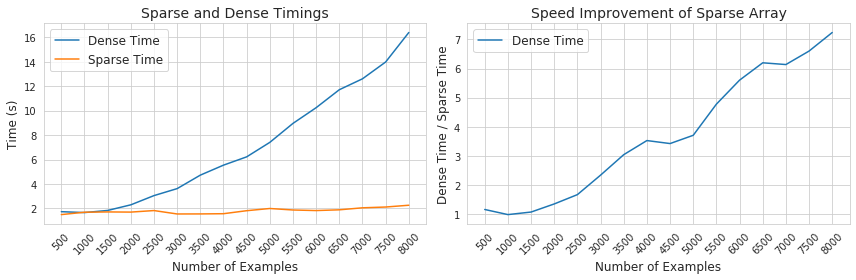

In [23]:
ratio = numpy.array(times) / numpy.array(sparse_times)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Sparse and Dense Timings", fontsize=14)
plt.plot(times, label="Dense Time")
plt.plot(sparse_times, label="Sparse Time")
plt.legend(fontsize=12)
plt.xticks(range(len(sizes)), sizes, rotation=45)
plt.xlabel("Number of Examples", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)

plt.subplot(122)
plt.title("Speed Improvement of Sparse Array", fontsize=14)
plt.plot(ratio, label="Dense Time")
plt.legend(fontsize=12)
plt.xticks(range(len(sizes)), sizes, rotation=45)
plt.xlabel("Number of Examples", fontsize=12)
plt.ylabel("Dense Time / Sparse Time", fontsize=12)

plt.tight_layout()
plt.show()

In [24]:
ps = 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99, 0.995, 0.999
times, sparse_times = [], []
for p in ps:
    X = numpy.random.uniform(0, 1, size=(2000, 2000)).astype('float64')
    X = (X + X.T) / 2
    X[X <= p] = 0
    
    tic = time.time()
    FacilityLocationSelection(500, 'precomputed', optimizer='naive', verbose=True).fit(X)
    times.append(time.time() - tic)
    
    X = csr_matrix(X)

    tic = time.time()
    FacilityLocationSelection(500, 'precomputed', optimizer='naive', verbose=True).fit(X)
    sparse_times.append(time.time() - tic)

100%|██████████| 500/500 [00:00<00:00, 4.02kit/s]


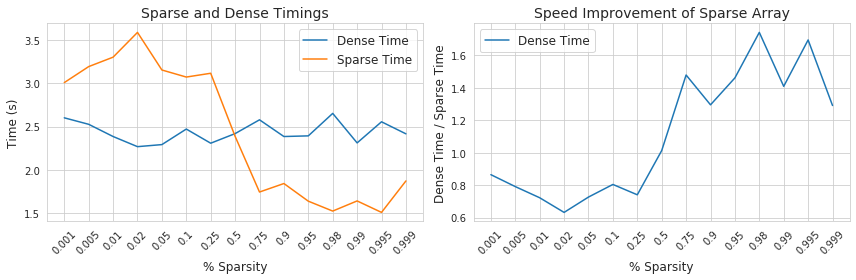

In [25]:
ratio = numpy.array(times) / numpy.array(sparse_times)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Sparse and Dense Timings", fontsize=14)
plt.plot(times, label="Dense Time")
plt.plot(sparse_times, label="Sparse Time")
plt.legend(fontsize=12)
plt.xticks(range(len(ps)), ps, rotation=45)
plt.xlabel("% Sparsity", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)

plt.subplot(122)
plt.title("Speed Improvement of Sparse Array", fontsize=14)
plt.plot(ratio, label="Dense Time")
plt.legend(fontsize=12)
plt.xticks(range(len(ps)), ps, rotation=45)
plt.xlabel("% Sparsity", fontsize=12)
plt.ylabel("Dense Time / Sparse Time", fontsize=12)

plt.tight_layout()
plt.show()

Similarly to feature based selection, using a sparse array is only faster than a dense array when the array gets to a certain level of sparsity, but can then be significantly faster.